Для удобства пользуйтесь Table of contents в колабе, я старался в более-менее аккуратный вид привести


Включил в колабе возможность оставлять комментарии к ноутбуку

Отсутствие очепяток в тексте не гарантирую

# Работа с датасетом

Перешел на работу с разреженными матрицами, поскольку это кажется уместным в нашем подходе, тем более датасет располагает. Думаю, до этого была проблема с тем, что из-за наличия нулей в строках пользователя наши модели думали, что 0 == плохая оценка, а потому сильно снижался RMSE (ведь случался перекос в сторону нулей при нормализации по L2, если я правильно понимаю). [но это не точно]. Поэтому теперь возникла необходимость переработки кода с baseline и optuna, думаю, это не займет слишком много времени, но пока сделать не успел. Так что пока возникают сомнения, а действительно ли получится RMSE меньше 1 сделать или это тогда просто ошибка в рассуждениях была (ведь с использованием оптимизации гиперпараметров и L2 нормализации получался около 0.2, как на графике из первого отчета видно было...)

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q ml-100k.zip

--2025-05-04 20:08:11--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  22.1MB/s    in 0.2s    

2025-05-04 20:08:11 (22.1 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]

replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ml-100k/mku.sh? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ml-100k/mku.sh? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import pandas as pd
import numpy as np

col_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('ml-100k/u.data', sep='\t', names=col_names)
print("Общее количество оценок:", data.shape[0])
data.head()

Общее количество оценок: 100000


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
display(data["rating"].describe())

,rating
count,100000.000000
mean,3.529860
std,1.125674
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


In [ ]:
from sklearn.model_selection import train_test_split

# выделяем тестовую часть (20%) и оставляем 80% для train+val
train_valid, test = train_test_split(data, test_size=0.2, random_state=42)

train, valid = train_test_split(train_valid, test_size=0.25, random_state=42)

print("Train data shape:", train.shape)
print("Test data shape:", test.shape)
print("Valid data shape:", valid.shape)

Train data shape: (60000, 4)
Test data shape: (20000, 4)
Valid data shape: (20000, 4)


In [ ]:
n_users, n_items = data.user_id.nunique(), data.item_id.nunique()

Подготовка данных с масштабированием к 1.0

Работаем с разреженной матрицей, поскольку у нас очень много нулей.

In [ ]:
from scipy import sparse

train['rating_scaled'] = train['rating'] / 5.0
valid['rating_scaled'] = valid['rating'] / 5.0
test ['rating_scaled'] = test ['rating'] / 5.0

def build_sparse(df, col='rating_scaled'):
    rows = df.user_id.values - 1          # 0-based
    cols = df.item_id.values - 1
    vals = df[col].values
    return sparse.coo_matrix((vals, (rows, cols)), shape=(n_users, n_items)).tocsr()

R_train_scaled = build_sparse(train)
R_val_scaled   = build_sparse(valid)
R_test_scaled = build_sparse(test)

R_train= build_sparse(train, col="rating")
R_val  = build_sparse(valid, col="rating")
R_test = build_sparse(test, col="rating")



In [ ]:
print(R_train_scaled)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 60000 stored elements and shape (943, 1682)>
  Coords	Values
  (0, 1)	0.6
  (0, 4)	0.6
  (0, 6)	0.8
  (0, 8)	1.0
  (0, 9)	0.6
  (0, 10)	0.4
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 16)	0.6
  (0, 17)	0.8
  (0, 18)	1.0
  (0, 22)	0.8
  (0, 24)	0.8
  (0, 26)	0.4
  (0, 27)	0.8
  (0, 28)	0.2
  (0, 29)	0.6
  (0, 32)	0.8
  (0, 34)	0.2
  (0, 35)	0.4
  (0, 38)	0.8
  (0, 39)	0.6
  :	:
  (942, 584)	0.2
  (942, 594)	0.4
  (942, 624)	0.6
  (942, 654)	0.8
  (942, 719)	0.2
  (942, 720)	1.0
  (942, 723)	0.2
  (942, 738)	0.8
  (942, 755)	0.4
  (942, 762)	0.8
  (942, 784)	0.4
  (942, 795)	0.6
  (942, 807)	0.8
  (942, 815)	0.8
  (942, 824)	0.6
  (942, 830)	0.4
  (942, 839)	0.8
  (942, 940)	0.2
  (942, 942)	1.0
  (942, 1010)	0.4
  (942, 1027)	0.4
  (942, 1043)	0.6
  (942, 1046)	0.4
  (942, 1227)	0.6
  (942, 1329)	0.6


In [ ]:
print(R_train)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 60000 stored elements and shape (943, 1682)>
  Coords	Values
  (0, 1)	3
  (0, 4)	3
  (0, 6)	4
  (0, 8)	5
  (0, 9)	3
  (0, 10)	2
  (0, 11)	5
  (0, 12)	5
  (0, 13)	5
  (0, 14)	5
  (0, 15)	5
  (0, 16)	3
  (0, 17)	4
  (0, 18)	5
  (0, 22)	4
  (0, 24)	4
  (0, 26)	2
  (0, 27)	4
  (0, 28)	1
  (0, 29)	3
  (0, 32)	4
  (0, 34)	1
  (0, 35)	2
  (0, 38)	4
  (0, 39)	3
  :	:
  (942, 584)	1
  (942, 594)	2
  (942, 624)	3
  (942, 654)	4
  (942, 719)	1
  (942, 720)	5
  (942, 723)	1
  (942, 738)	4
  (942, 755)	2
  (942, 762)	4
  (942, 784)	2
  (942, 795)	3
  (942, 807)	4
  (942, 815)	4
  (942, 824)	3
  (942, 830)	2
  (942, 839)	4
  (942, 940)	1
  (942, 942)	5
  (942, 1010)	2
  (942, 1027)	2
  (942, 1043)	3
  (942, 1046)	2
  (942, 1227)	3
  (942, 1329)	3


In [ ]:
print("R_train_scaled:", R_train_scaled.shape, "nnz =", R_train_scaled.nnz)
print("R_val_scaled  :", R_val_scaled.shape,   "nnz =", R_val_scaled.nnz)
print("R_test_scaled :", R_test_scaled.shape,  "nnz =", R_test_scaled.nnz)

R_train_scaled: (943, 1682) nnz = 60000
R_val_scaled  : (943, 1682) nnz = 20000
R_test_scaled : (943, 1682) nnz = 20000


На этом с предобрабткой данных всё

# Классический ML (наш baseline)

In [ ]:
%pip install optuna

### Classic SVD

In [ ]:
import optuna
import time
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

def objective_svd(trial):
    # гиперпараметры
    n_components = trial.suggest_int("n_components", 5, 50)
    n_iter       = trial.suggest_int("n_iter", 5, 30)

    start_time = time.time()
    svd = TruncatedSVD(n_components=n_components, n_iter=n_iter, random_state=42)
    U = svd.fit_transform(R_train_scaled)    # обучаем на train
    S = svd.singular_values_
    V = svd.components_
    # восстановленная матрица [0,1]
    R_hat = U.dot(np.diag(S)).dot(V)
    elapsed = time.time() - start_time

    # берем ненулевые элементы валидационной матрицы
    user_idx, item_idx = R_val_scaled.nonzero()

    # истинные рейтинги в шкале [1,5]
    y_true = R_val_scaled[user_idx, item_idx].A1 * 5.0
    # предсказанные рейтинги в шкале [1,5]
    y_pred = R_hat[user_idx, item_idx] * 5.0
    y_pred = np.clip(y_pred, 1.0, 5.0)

    # считаем RMSE и MAE
    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)

    trial.set_user_attr("mae", mae)
    trial.set_user_attr("time_sec", elapsed)
    return rmse

# поиск по валидации
study_svd = optuna.create_study(direction="minimize")
study_svd.optimize(objective_svd, n_trials=5)

print("Лучшие параметры SVD:", study_svd.best_trial.params)
print(f"RMSE на валидации (1–5): {study_svd.best_trial.value:.4f}")
print(f"MAE на валидации  (1–5): {study_svd.best_trial.user_attrs['mae']:.4f}")
print(f"Время обучения лучшей модели: {study_svd.best_trial.user_attrs['time_sec']:.2f} сек")


[I 2025-05-04 20:09:17,319] A new study created in memory with name: no-name-8afd5fd1-c7e8-4c7c-a076-adf937cd317d
[I 2025-05-04 20:09:17,658] Trial 0 finished with value: 1.79870376092476 and parameters: {'n_components': 24, 'n_iter': 16}. Best is trial 0 with value: 1.79870376092476.
[I 2025-05-04 20:09:18,256] Trial 1 finished with value: 1.7998558641379208 and parameters: {'n_components': 40, 'n_iter': 13}. Best is trial 0 with value: 1.79870376092476.
[I 2025-05-04 20:09:18,932] Trial 2 finished with value: 1.7994128832879368 and parameters: {'n_components': 50, 'n_iter': 14}. Best is trial 0 with value: 1.79870376092476.
[I 2025-05-04 20:09:21,168] Trial 3 finished with value: 1.7984466415196727 and parameters: {'n_components': 23, 'n_iter': 28}. Best is trial 3 with value: 1.7984466415196727.
[I 2025-05-04 20:09:24,019] Trial 4 finished with value: 1.799821451719316 and parameters: {'n_components': 47, 'n_iter': 7}. Best is trial 3 with value: 1.7984466415196727.


Лучшие параметры SVD: {'n_components': 23, 'n_iter': 28}
RMSE на валидации (1–5): 1.7984
MAE на валидации  (1–5): 1.4271
Время обучения лучшей модели: 2.20 сек


In [ ]:
# --- после того как выбрали гиперпараметры, можно финально оценить на тесте: ---
best_k_svd      = study_svd.best_trial.params["n_components"]
best_n_iter_svd = study_svd.best_trial.params["n_iter"]

svd_best = TruncatedSVD(n_components=best_k_svd, n_iter=best_n_iter_svd, random_state=42)
U = svd_best.fit_transform(R_train_scaled)
S = svd_best.singular_values_
V = svd_best.components_
R_hat_test = U.dot(np.diag(S)).dot(V)

uidx, iid = R_test_scaled.nonzero()
y_true_test = R_test_scaled[uidx, iid].A1 * 5.0
y_pred_test = R_hat_test[uidx, iid] * 5.0
y_pred_test = np.clip(y_pred_test, 1.0, 5.0)

rmse_test = root_mean_squared_error(y_true_test, y_pred_test)
mae_test  = mean_absolute_error(y_true_test, y_pred_test)
print(f"\nИтоговая проверка на тесте:")
print(f"RMSE (1–5): {rmse_test:.4f}")
print(f"MAE  (1–5): {mae_test:.4f}")


Итоговая проверка на тесте:
RMSE (1–5): 1.8070
MAE  (1–5): 1.4350


In [ ]:
trials_svd_df = study_svd.trials_dataframe()
trials_svd_df

,number,value,datetime_start,datetime_complete,duration,params_n_components,params_n_iter,user_attrs_mae,user_attrs_time_sec,state
0,0,1.798704,2025-05-04 20:09:17.321208,2025-05-04 20:09:17.658163,0 days 00:00:00.336955,24,16,1.427273,0.324647,COMPLETE
1,1,1.799856,2025-05-04 20:09:17.670666,2025-05-04 20:09:18.256411,0 days 00:00:00.585745,40,13,1.427516,0.579948,COMPLETE
2,2,1.799413,2025-05-04 20:09:18.265695,2025-05-04 20:09:18.932021,0 days 00:00:00.666326,50,14,1.427340,0.637099,COMPLETE
3,3,1.798447,2025-05-04 20:09:18.941918,2025-05-04 20:09:21.168462,0 days 00:00:02.226544,23,28,1.427115,2.196157,COMPLETE
4,4,1.799821,2025-05-04 20:09:21.174015,2025-05-04 20:09:24.019298,0 days 00:00:02.845283,47,7,1.427349,2.826714,COMPLETE


### ALS из яндекс хендбука

In [ ]:
import optuna
import time
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def als_train(R, n_factors, reg, n_iter):
    m, n = R.shape
    U = np.random.normal(scale=1.0/n_factors, size=(m, n_factors))
    V = np.random.normal(scale=1.0/n_factors, size=(n, n_factors))
    I = np.eye(n_factors)
    R_csr = R.tocsr()
    R_csc = R.tocsc()

    for _ in range(n_iter):
        # обновляем U
        for u in range(m):
            start, end = R_csr.indptr[u], R_csr.indptr[u+1]
            idx = R_csr.indices[start:end]
            if idx.size == 0:
                continue
            Vj  = V[idx]               # (C_u, factors)
            Rij = R_csr.data[start:end]
            Cu  = idx.size
            A   = Vj.T @ Vj + reg * Cu * I
            b   = Vj.T @ Rij
            U[u] = np.linalg.solve(A, b)

        # обновляем V
        for i in range(n):
            start, end = R_csc.indptr[i], R_csc.indptr[i+1]
            idx = R_csc.indices[start:end]
            if idx.size == 0:
                continue
            Ui  = U[idx]               # (C_i, factors)
            Rij = R_csc.data[start:end]
            Ci  = idx.size
            A   = Ui.T @ Ui + reg * Ci * I
            b   = Ui.T @ Rij
            V[i] = np.linalg.solve(A, b)

    return U, V

def objective_als(trial):
    n_factors = trial.suggest_int   ("n_factors", 5, 50)
    reg       = trial.suggest_float ("reg",       1e-5, 1.0, log=True)
    n_iter    = trial.suggest_int   ("n_iter",    5,  20)

    t0 = time.time()
    U, V = als_train(R_train_scaled, n_factors, reg, n_iter)
    elapsed = time.time() - t0

    # предсказания
    R_hat = U @ V.T

    # RMSE/MAE на валидации в шкале [1–5]
    ui, ii = R_val_scaled.nonzero()
    y_true = (R_val_scaled[ui, ii].A1) * 5.0
    y_pred = np.clip(R_hat[ui, ii] * 5.0, 1.0, 5.0)

    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)

    trial.set_user_attr("mae", mae)
    trial.set_user_attr("time_sec", elapsed)
    return rmse

# оптимизация
study_als = optuna.create_study(direction="minimize")
study_als.optimize(objective_als, n_trials=2)

print("Лучшие параметры ALS:", study_als.best_trial.params)
print(f"RMSE на валидации (1–5): {study_als.best_trial.value:.4f}")
print(f"MAE  на валидации (1–5): {study_als.best_trial.user_attrs['mae']:.4f}")
print(f"Время обучения: {study_als.best_trial.user_attrs['time_sec']:.2f} сек")

[I 2025-05-04 20:09:24,726] A new study created in memory with name: no-name-d733947e-e03c-4dd1-9b71-3372bdef6725
[I 2025-05-04 20:09:56,045] Trial 0 finished with value: 1.4958549797158829 and parameters: {'n_factors': 50, 'reg': 1.8282681308546525e-05, 'n_iter': 15}. Best is trial 0 with value: 1.4958549797158829.
[I 2025-05-04 20:10:06,113] Trial 1 finished with value: 2.771831524461759 and parameters: {'n_factors': 7, 'reg': 0.697511719987936, 'n_iter': 18}. Best is trial 0 with value: 1.4958549797158829.


Лучшие параметры ALS: {'n_factors': 50, 'reg': 1.8282681308546525e-05, 'n_iter': 15}
RMSE на валидации (1–5): 1.4959
MAE  на валидации (1–5): 1.1779
Время обучения: 31.17 сек


In [ ]:
trials_svd_df = study_svd.trials_dataframe()
trials_svd_df

,number,value,datetime_start,datetime_complete,duration,params_n_components,params_n_iter,user_attrs_mae,user_attrs_time_sec,state
0,0,1.798704,2025-05-04 20:09:17.321208,2025-05-04 20:09:17.658163,0 days 00:00:00.336955,24,16,1.427273,0.324647,COMPLETE
1,1,1.799856,2025-05-04 20:09:17.670666,2025-05-04 20:09:18.256411,0 days 00:00:00.585745,40,13,1.427516,0.579948,COMPLETE
2,2,1.799413,2025-05-04 20:09:18.265695,2025-05-04 20:09:18.932021,0 days 00:00:00.666326,50,14,1.427340,0.637099,COMPLETE
3,3,1.798447,2025-05-04 20:09:18.941918,2025-05-04 20:09:21.168462,0 days 00:00:02.226544,23,28,1.427115,2.196157,COMPLETE
4,4,1.799821,2025-05-04 20:09:21.174015,2025-05-04 20:09:24.019298,0 days 00:00:02.845283,47,7,1.427349,2.826714,COMPLETE


## Анализ классики

Лучшие параметры SVD: {'n_components': 23, 'n_iter': 28}
Лучшие параметры ALS: {'n_factors': 50, 'reg': 1.8282681308546525e-05, 'n_iter': 15}
  Метод      RMSE       MAE  Время (секунд)
0   SVD  1.829294  1.454422        2.196157
1   ALS  1.433703  1.117129       53.172751


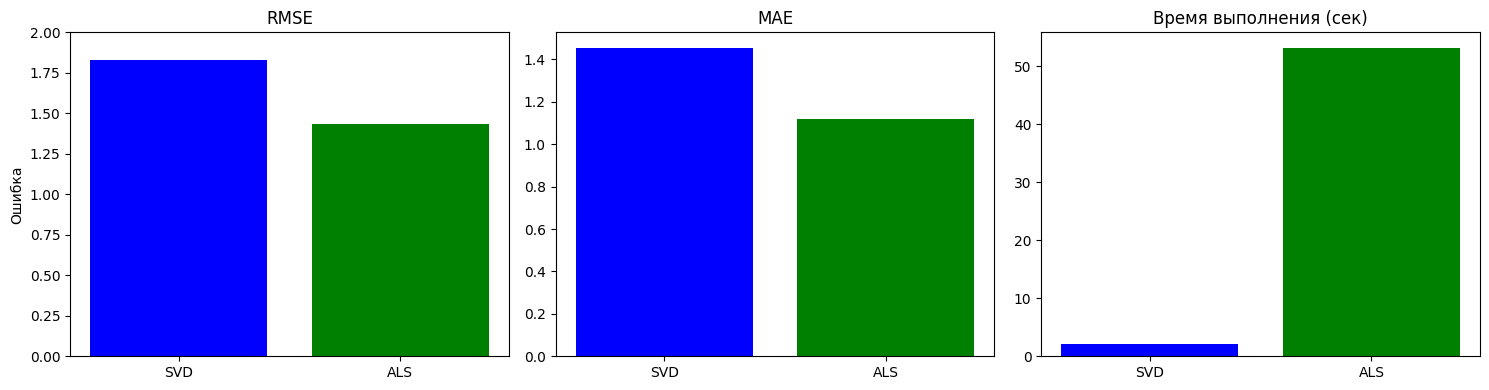

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# итоговый train+val
R_train_full = build_sparse(pd.concat([train, valid]), col='rating_scaled')

# ----
# SVD на train+val -> test
# ----
best_svd_params = study_svd.best_trial.params
best_k_svd      = best_svd_params["n_components"]
best_n_iter_svd = best_svd_params["n_iter"]
print("Лучшие параметры SVD:", best_svd_params)

svd_best = TruncatedSVD(n_components=best_k_svd, n_iter=best_n_iter_svd, random_state=42)
U_svd = svd_best.fit_transform(R_train_full)
S_svd = svd_best.singular_values_
V_svd = svd_best.components_
R_hat_svd = U_svd.dot(np.diag(S_svd)).dot(V_svd)

uidx, iid = R_test_scaled.nonzero()
y_true_svd = R_test_scaled[uidx, iid].A1 * 5.0
y_pred_svd = np.clip(R_hat_svd[uidx, iid] * 5.0, 1.0, 5.0)

rmse_svd = root_mean_squared_error(y_true_svd, y_pred_svd)
mae_svd  = mean_absolute_error(y_true_svd, y_pred_svd)
runtime_svd = study_svd.best_trial.user_attrs["time_sec"]

# ----
# ALS на train+val -> test
# ----
best_als_params = study_als.best_trial.params
print("Лучшие параметры ALS:", best_als_params)

n_factors = best_als_params["n_factors"]
reg       = best_als_params["reg"]
n_iter    = best_als_params["n_iter"]

# обучаем финальную ALS на train+val
t0 = time.time()
U_als, V_als = als_train(R_train_full, n_factors, reg, n_iter)
runtime_als = time.time() - t0

R_hat_als = U_als.dot(V_als.T)

# оценки на тесте
y_true_als = R_test_scaled[uidx, iid].A1 * 5.0
y_pred_als = np.clip(R_hat_als[uidx, iid] * 5.0, 1.0, 5.0)

rmse_als = root_mean_squared_error(y_true_als, y_pred_als)
mae_als  = mean_absolute_error(y_true_als, y_pred_als)

# --------
# Сравнение
# --------
df_compare = pd.DataFrame({
    "Метод": ["SVD", "ALS"],
    "RMSE": [rmse_svd, rmse_als],
    "MAE": [mae_svd, mae_als],
    "Время (секунд)": [runtime_svd, runtime_als]
})
print(df_compare)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].bar(df_compare["Метод"], df_compare["RMSE"], color=["blue","green"])
axs[0].set_title("RMSE")
axs[0].set_ylabel("Ошибка")
axs[0].set_ylim([0,2])

axs[1].bar(df_compare["Метод"], df_compare["MAE"], color=["blue","green"])
axs[1].set_title("MAE")
axs[0].set_ylim([0,2])


axs[2].bar(df_compare["Метод"], df_compare["Время (секунд)"], color=["blue","green"])
axs[2].set_title("Время выполнения (сек)")

plt.tight_layout()
plt.show()

In [ ]:
R_hat_als.shape

(943, 1682)

# Квантовая часть

In [ ]:
%pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.4 MB/s eta 0:00:00


## Предподготовка гиперпараметров и латентных векторов для симулятора

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from tqdm.notebook import tqdm
import pandas as pd, math, random, time

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [ ]:
# Гиперпараметры
k = 4 # dimensional reduction
n_lat = int(np.ceil(np.log2(k)))
dim   = 2 ** n_lat

In [ ]:
# Классический SVD [0,1]
svd = TruncatedSVD(n_components=k, random_state=0)
U   = svd.fit_transform(R_train_scaled)       # (m,k)
S   = svd.singular_values_
Σrt = np.diag(np.sqrt(S))
Vt  = svd.components_                         # (k,n)

user_lat  = U @ Σrt                           # (m,k)
item_latT = Σrt @ Vt                          # (k,n)

# # NMF на [0,1]
# nmf = NMF(n_components=k, init='nndsvda', random_state=0, max_iter=500)
# W   = nmf.fit_transform(R_train_scaled)       # (m,k)
# H   = nmf.components_                         # (k,n)

print("SVD обучен на нормированных данных")

SVD обучен на нормированных данных


## SWAP-тест (Amplitude encoding)

### Реализация подхода

In [ ]:
dev_swap = qml.device("default.qubit", wires=1+2*n_lat)

@qml.qnode(dev_swap)
def swap_test(u_vec, v_vec):
    qml.Hadamard(0)
    qml.AmplitudeEmbedding(u_vec, wires=range(1, 1+n_lat), normalize=True)
    qml.AmplitudeEmbedding(v_vec, wires=range(1+n_lat, 1+2*n_lat), normalize=True)
    for a, b in zip(range(1, 1+n_lat), range(1+n_lat, 1+2*n_lat)):
        qml.CSWAP([0, a, b])
    qml.Hadamard(0)
    return qml.probs(0)

In [ ]:
def to_amp(v, power2_len=dim):
    v = np.asarray(v, dtype=float)
    v = np.pad(v, (0, power2_len - v.size)) # zero-padding
    norm = np.linalg.norm(v)

    if norm < 1e-12: # нулевой вектор
        vec = np.zeros_like(v)
        vec[0] = 1.0
        return vec

    return v / norm

In [ ]:
def dot_q(u, v):
    p0, _ = swap_test(to_amp(u), to_amp(v))
    return (2*p0 - 1) * (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
def predict_pair(user, item):
    u = user_lat[user]              # k-dim вектор
    v = item_latT[:, item]          # k-dim вектор
    return dot_q(u, v)

def quantum_predict(df, max_pairs=None):
    start = time.perf_counter()
    rows = df if max_pairs is None else df.sample(max_pairs, random_state=42)
    preds = []
    for (_,u,i,r,_) in rows.itertuples():
        preds.append(predict_pair(u-1, i-1))
    exec_time = time.perf_counter() - start
    return np.array(preds), rows.rating.values, exec_time

In [ ]:
def predict_svd(u, i):
    return np.dot(user_lat[u], item_latT[:, i])

# def predict_nmf(u, i):
#     return np.dot(W[u], H[:, i])

### Сравнение swap с классикой

In [ ]:
rows = test.sample(100, random_state=0)

true_raw   = rows['rating'].to_numpy(dtype=float) # [1,5]
true_scale = true_raw / 5.0 # [0,1]

pred_q_scale  = np.empty(len(rows))
pred_svd_scale= np.empty(len(rows))
# pred_nmf_scale= np.empty(len(rows))

for idx, row in enumerate(rows.itertuples(index=False)):
    u, i, rating, ts, rating_scaled = row
    u -= 1; i -= 1 # 0-based индексы
    pred_q_scale [idx] = np.clip(dot_q(user_lat[u], item_latT[:, i]), 0, 1)
    pred_svd_scale[idx] = np.clip(predict_svd(u, i), 0, 1)
    # pred_nmf_scale[idx] = np.clip(predict_nmf(u, i), 0, 1)

pred_q   = pred_q_scale   * 5
pred_svd = pred_svd_scale * 5
# pred_nmf = pred_nmf_scale * 5

rmse  = root_mean_squared_error
mae   = mean_absolute_error

print("  MODEL   |   RMSE |   MAE")
print(f"Quant-Amp | {rmse(true_raw, pred_q ):.4f} | {mae(true_raw, pred_q ):.4f}")
print(f"SVD       | {rmse(true_raw, pred_svd):.4f} | {mae(true_raw, pred_svd):.4f}")
# print(f"NMF       | {rmse(true_raw, pred_nmf):.4f} | {mae(true_raw, pred_nmf):.4f}")

  MODEL   |   RMSE |   MAE
Quant-Amp | 1.8575 | 1.4491
SVD       | 1.8805 | 1.4672


## Angle encoding


In [ ]:
pairs_df = train.sample(100, random_state=42).reset_index(drop=True)

# # train : val = 80 : 20
# split = int(0.8 * len(pairs_df))
# train_pairs = pairs_df.iloc[:split ].reset_index(drop=True)
# val_pairs   = pairs_df.iloc[ split:].reset_index(drop=True)

train_pairs = train
val_pairs = valid

In [ ]:
def pair_to_lat(row):
    """возвращает (u_lat_vec, i_lat_vec, true_rating)"""
    u, i, r, ts, r_scaled = row
    return (
        user_lat[u-1],
        item_latT[:, i-1],
        float(r)
    )

In [ ]:
def vec_to_angles(vec):
    """
    Принимаем k-мерный вектор в диапазоне [0,1] и
    масштабируем его к углам (0 ... pi)   — достаточно
    для RY-вращений, а диапазон остаётся неотрицательным.
    """
    return np.asarray(vec) * np.pi          # (k,)

In [ ]:
def layer_entangle():
    for a, b in zip(range(k), range(k, 2*k)):
        qml.CNOT(wires=[a, b])

In [ ]:
def rmse_np(y, p): return np.sqrt(((y - p) ** 2).mean())

### Гиперпараметры и реализация

In [ ]:
# --- гиперпараметры  ---
n_qubits   = 2 * k
n_layers   = 2
lr         = 0.08
epochs     = 1
batch_size = 4

In [ ]:
dev_var = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_var, interface="autograd")
def var_net(u_angles, v_angles, weights):
    qml.AngleEmbedding(u_angles, wires=range(k), rotation="Y")
    qml.AngleEmbedding(v_angles, wires=range(k, 2*k), rotation="Y")

    # L параметризуемых слоёв
    for l in range(n_layers):
        for q in range(2*k):
            qml.RY(weights[l, q], wires=q)
        layer_entangle()

    return qml.expval(qml.PauliZ(0))

In [ ]:
def predict_pair_ang(u_vec, i_vec, w, s, b):
    exp_z = var_net(vec_to_angles(u_vec), vec_to_angles(i_vec), w)
    return exp_z * s + b

### Обучение

In [ ]:
import pennylane.numpy as pnp

# ---------- обучаемые параметры ----------
weights = 0.01 * pnp.random.randn(n_layers, 2*k, requires_grad=True)
scale   = pnp.tensor(2.0, requires_grad=True)
bias    = pnp.tensor(3.0, requires_grad=True)

params = (weights, scale, bias)

# ---------- оптимизатор ----------
opt = qml.optimize.AdamOptimizer(stepsize=0.05)
batch_size = 16
max_epochs = 1
patience   = 2

best_val = math.inf
pat_cnt  = 0

In [ ]:
def mse_on_batch(w, s, b, rows):
    preds, trues = [], []
    for row in rows.itertuples(index=False):
        u_vec, i_vec, r_true = pair_to_lat(row)
        preds.append(predict_pair_ang(u_vec, i_vec, w, s, b))
        trues.append(r_true)
    return pnp.mean((pnp.array(preds) - pnp.array(trues))**2)

grad_fn = qml.grad(lambda w,s,b,rows: mse_on_batch(w,s,b,rows))

def rows_to_batches(df, bs):
    idx = np.arange(len(df)); np.random.shuffle(idx)
    for i in range(0, len(df), bs):
        yield df.iloc[idx[i:i+bs]]

In [ ]:
import pickle
from tqdm.auto import tqdm

# путь для сохранения лучших параметров
BEST_PARAMS_PATH = "best_quant_params.pkl"

# ---------- цикл обучения ----------
batch_count = (len(train_pairs) + batch_size - 1) // batch_size
for epoch in range(1, max_epochs + 1):
    # прогресс-бар по батчам в этой эпохе
    for batch in tqdm(
            rows_to_batches(train_pairs, batch_size),
            desc=f"Epoch {epoch}",
            total=batch_count,
            unit="batch",
        ):
        weights, scale, bias = opt.step(
            lambda w, s, b: mse_on_batch(w, s, b, batch),
            weights, scale, bias
        )

    # ----- валидация -----
    val_preds = [
        predict_pair_ang(user_lat[u-1], item_latT[:, i-1], weights, scale, bias)
        for u, i, r, ts, rs in val_pairs.itertuples(index=False)
    ]
    val_rmse = rmse_np(
        val_pairs['rating'].values.astype(float),
        np.array(val_preds)
    )
    print(f"epoch {epoch:3d}: val-RMSE = {val_rmse:.4f}")

    if val_rmse + 1e-4 < best_val:
        best_val = val_rmse
        best_params = (weights.copy(), scale.copy(), bias.copy())
        pat_cnt = 0

        # сохраняем текущие лучшие параметры на диск
        with open(BEST_PARAMS_PATH, "wb") as f:
            pickle.dump({
                "weights": best_params[0],
                "scale":   best_params[1],
                "bias":    best_params[2],
                "epoch":   epoch,
                "val_rmse": best_val
            }, f)

    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print("early stopping")
            break

# после завершения цикла загружаем из памяти лучшие параметры
weights_opt, scale_opt, bias_opt = best_params
print("Лучший val-RMSE:", best_val)
print(f"Параметры также сохранены в {BEST_PARAMS_PATH}")

Epoch 1:   0%|          | 0/3750 [00:00<?, ?batch/s]

epoch   1: val-RMSE = 1.1248
Лучший val-RMSE: 1.1247623801311815
Параметры также сохранены в best_quant_params.pkl


### Быстрое стартовое сравнение

In [ ]:
rmse = root_mean_squared_error
mae = mean_absolute_error

n_eval = 100
sample = test.sample(n_eval, random_state=42).reset_index(drop=True)

true   = sample['rating'].to_numpy(dtype=float)
angvar = np.empty(n_eval)
amp    = np.empty(n_eval)
svd4   = np.empty(n_eval)
# nmf4   = np.empty(n_eval)

for idx, row in tqdm(enumerate(sample.itertuples(index=False)), total=n_eval):
    u,i,r,ts,rs = row
    u -= 1; i -= 1

    # ---- Angle ----
    angvar[idx] = predict_pair_ang(user_lat[u], item_latT[:, i],
                                   weights_opt, scale_opt, bias_opt)

    # ---- Amplitude ----
    amp[idx] = np.clip(np.dot(user_lat[u], item_latT[:, i]), 0, 1) * 5

    # ---- Classic ----
    svd4[idx] = np.clip(np.dot(user_lat[u], item_latT[:, i]), 0, 1) * 5
    # nmf4[idx] = np.clip(np.dot(W[u], H[:, i]), 0, 1) * 5

print("\n=== Метрики на", n_eval, "парах ===")
def line(name, pred):
    print(f"{name:<10} | {rmse(true,pred):7.4f} | {mae(true,pred):7.4f}")
print("Model      |  RMSE   |  MAE")
line("Angle-var", angvar)
line("Amplitude", amp)
line(f"SVD k={k}",  svd4)
# line("NMF k=4",  nmf4)

  0%|          | 0/100 [00:00<?, ?it/s]


=== Метрики на 100 парах ===
Model      |  RMSE   |  MAE
Angle-var  |  1.0460 |  0.8679
Amplitude  |  1.7437 |  1.4204
SVD k=4    |  1.7437 |  1.4204


### Предсказания

подготовка к предсказаниям на подвыборке

In [ ]:
# ─── ЯЧЕЙКА 1: SPLIT НА TRAIN / VALID / TEST ───
from sklearn.model_selection import train_test_split

# параметры
TEST_SIZE    = 0.2
VAL_SIZE     = 0.2          # доля валидации от всей выборки
RANDOM_STATE = 42
TIME_BASED_SPLIT = True
SUBSET_USERS = None          # или None

df = data.copy()

# переиндексация ID подряд с 0
user_map = {old: new for new, old in enumerate(sorted(df.user_id.unique()))}
item_map = {old: new for new, old in enumerate(sorted(df.item_id.unique()))}
df["user_id"] = df.user_id.map(user_map)
df["item_id"] = df.item_id.map(item_map)

# сокращаем число пользователей, если нужно
if SUBSET_USERS is not None:
    users = sorted(df.user_id.unique())[:SUBSET_USERS]
    df = df[df.user_id.isin(users)].reset_index(drop=True)

if TIME_BASED_SPLIT:
    df = df.sort_values("timestamp").reset_index(drop=True)
    # сначала отделяем тест
    cut1      = int(len(df) * (1 - TEST_SIZE))
    train_val = df.iloc[:cut1].reset_index(drop=True)
    test_df   = df.iloc[cut1:].reset_index(drop=True)
    # теперь делим train_val на train и valid
    val_ratio = VAL_SIZE / (1 - TEST_SIZE)
    cut2      = int(len(train_val) * (1 - val_ratio))
    train_df  = train_val.iloc[:cut2].reset_index(drop=True)
    valid_df  = train_val.iloc[cut2:].reset_index(drop=True)
else:
    # случайный двухшаговый сплит
    train_val, test_df = train_test_split(
        df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
    )
    train_df, valid_df = train_test_split(
        train_val,
        test_size=VAL_SIZE/(1-TEST_SIZE),
        random_state=RANDOM_STATE,
        shuffle=True
    )

print(f"Train: {train_df.shape}, Valid: {valid_df.shape}, Test: {test_df.shape}")
print(" Train mean:", train_df.rating.mean().round(3),
      "\n Valid mean:", valid_df.rating.mean().round(3),
      "\n Test mean:",  test_df.rating.mean().round(3))


Train: (60000, 4), Valid: (20000, 4), Test: (20000, 4)
 Train mean: 3.561 
 Valid mean: 3.387 
 Test mean: 3.579


In [ ]:
train_df

,user_id,item_id,rating,timestamp
0,258,254,4,874724710
1,258,285,4,874724727
2,258,297,4,874724754
3,258,184,4,874724781
4,258,172,4,874724843
...,...,...,...,...
59995,920,201,4,884673891
59996,920,650,3,884673891
59997,920,96,2,884673891
59998,920,754,4,884673910


In [ ]:
# функция проверки
def check_dataframe(df, name):
    rmse = np.sqrt(((df.rating - df.quantum_pred)**2).mean())
    print(f"{name}: {len(df):,} rows, RMSE = {rmse:.4f}")

In [ ]:
# ─── ЯЧЕЙКА 2: QUANTUM PREDICTIONS НА TRAIN И VALID ───
from tqdm.auto import tqdm

def make_quant_preds(df_in, N_limit=None):
    sub = df_in if N_limit is None else df_in.head(N_limit).copy()
    preds = []
    for _, row in tqdm(sub.iterrows(), total=len(sub), desc="Quantum pred"):
        u, i = row.user_id, row.item_id
        preds.append(
            float(predict_pair_ang(
                user_lat[u], item_latT[:, i],
                weights_opt, scale_opt, bias_opt
            ))
        )
    sub["quantum_pred"] = preds
    sub["quantum_pred"] = sub.quantum_pred.clip(1.0, 5.0)
    sub["error"] = sub.rating - sub.quantum_pred
    return sub

# генерируем
train_lstm_df = make_quant_preds(train_df, N_limit=None)
valid_lstm_df = make_quant_preds(valid_df, N_limit=None)

# показываем статистику
print("Train stats:")
display(train_lstm_df[["error"]].describe().round(4))
print("\nValid stats:")
display(valid_lstm_df[["error"]].describe().round(4))

check_dataframe(train_lstm_df, "train_lstm_df")
check_dataframe(valid_lstm_df, "valid_lstm_df")

Quantum pred:   0%|          | 0/60000 [00:00<?, ?it/s]

Quantum pred:   0%|          | 0/20000 [00:00<?, ?it/s]

Train stats:


,error
count,60000.0000
mean,0.0444
std,1.1072
min,-2.6403
25%,-0.5533
50%,0.4228
75%,0.5594
max,1.6016



Valid stats:


,error
count,20000.0000
mean,-0.1410
std,1.1814
min,-2.6407
25%,-0.5982
50%,0.3676
75%,0.5340
max,1.6015


train_lstm_df: 60,000 rows, RMSE = 1.1081
valid_lstm_df: 20,000 rows, RMSE = 1.1897


In [ ]:
# ─── ЯЧЕЙКА 3: QUANTUM PREDICTIONS НА TEST + SAVE ───
from tqdm.auto import tqdm

test_lstm_df = make_quant_preds(test_df, N_limit=None)

check_dataframe(test_lstm_df, "test_lstm_df")

# (опционально) сохраняем
train_lstm_df.to_parquet("train_lstm.parquet", index=False)
valid_lstm_df.to_parquet("valid_lstm.parquet", index=False)
test_lstm_df.to_parquet ("test_lstm.parquet",  index=False)
print("Saved to *.parquet")

Quantum pred:   0%|          | 0/20000 [00:00<?, ?it/s]

test_lstm_df: 20,000 rows, RMSE = 1.1227
Saved to *.parquet


# LSTM

## Подготовка признаков

In [ ]:
# --- CONFIG ----------------------------------------------
CONT_FEATS   = ["quantum_pred"]     # непрерывные признаки
CAT_FEATS    = ["user_id", "item_id"]  # категориальные ID
NORMALIZE_QP = True # нормализовать quantum_pred в [0,1]
# ---------------------------------------------------------

def _prep_cont(df):
  """ Подготовка непрерывных признаков"""
  cont = df[CONT_FEATS].astype("float32").copy()
  if NORMALIZE_QP and "quantum_pred" in cont:
      cont["quantum_pred"] = (cont["quantum_pred"] - 1.0) / 4.0   # 1–5 -> 0–1
  return cont.values.astype("float32")

def _prep_cat(df):
  """ Подготовка категориальных признаков"""
  return df[CAT_FEATS].astype("int64").values

n_users = int(train_lstm_df["user_id"].max() + 1)
n_items = int(train_lstm_df["item_id"].max() + 1)
print(f"n_users={n_users:,}   n_items={n_items:,}")

n_users=943   n_items=1,682


In [ ]:
X_train_cont = _prep_cont(train_lstm_df) # (N, len(CONT_FEATS))
X_train_cat  = _prep_cat (train_lstm_df) # (N, len(CAT_FEATS))

y_train = train_lstm_df["error"].astype("float32").values

print("Train Shapes:")
print("   X_train_cont :", X_train_cont.shape)
print("   X_train_cat  :", X_train_cat.shape)
print("   y_train      :", y_train.shape)

Train Shapes:
   X_train_cont : (60000, 1)
   X_train_cat  : (60000, 2)
   y_train      : (60000,)


In [ ]:
# Аналогичная заготовка для валидации

if "quantum_pred" not in valid_lstm_df.columns:
    valid_lstm_df = valid_lstm_df.assign(
        quantum_pred = np.nan,
        error        = np.nan
    )

X_valid_cont = _prep_cont(valid_lstm_df)
X_valid_cat  = _prep_cat (valid_lstm_df)
y_valid      = valid_lstm_df["error"].astype("float32").values

print("Valid Shapes:")
print("   X_valid_cont :", X_valid_cont.shape)
print("   X_valid_cat  :", X_valid_cat.shape)

print("\n Пять случайных примеров:")
sample_idx = np.random.choice(len(valid_lstm_df), size=5, replace=False)
disp = valid_lstm_df.iloc[sample_idx][
    ["user_id","item_id","rating","quantum_pred","error"]
]
display(disp)

Valid Shapes:
   X_valid_cont : (20000, 1)
   X_valid_cat  : (20000, 2)

 Пять случайных примеров:


,user_id,item_id,rating,quantum_pred,error
19766,238,241,5,3.598522,1.401478
5959,536,177,4,3.576877,0.423123
7184,415,102,3,3.609820,-0.609820
10107,530,285,5,3.423734,1.576266
1617,918,304,4,3.524607,0.475393


In [ ]:
# Аналогичная заготовка для теста

if "quantum_pred" not in test_lstm_df.columns:
    test_lstm_df = test_lstm_df.assign(
        quantum_pred = np.nan,
        error        = np.nan
    )

X_test_cont = _prep_cont(test_lstm_df)
X_test_cat  = _prep_cat (test_lstm_df)
y_test      = test_lstm_df["error"].astype("float32").values

print("Test Shapes:")
print("   X_test_cont :", X_test_cont.shape)
print("   X_test_cat  :", X_test_cat.shape)

print("\n Пять случайных примеров:")
sample_idx = np.random.choice(len(test_lstm_df), size=5, replace=False)
disp = test_lstm_df.iloc[sample_idx][
    ["user_id","item_id","rating","quantum_pred","error"]
]
display(disp)

Test Shapes:
   X_test_cont : (20000, 1)
   X_test_cat  : (20000, 2)

 Пять случайных примеров:


,user_id,item_id,rating,quantum_pred,error
13829,334,322,4,3.567717,0.432283
19380,531,97,5,3.461897,1.538103
10990,355,688,5,3.448813,1.551187
3102,53,345,4,3.464807,0.535193
13601,222,328,2,3.478726,-1.478726


## Диапазон предсказаний Angle-Var

In [ ]:
print("\n Valid диапазон quantum_pred:",
      f"{valid_lstm_df.quantum_pred.min():.2f} ... {valid_lstm_df.quantum_pred.max():.2f}")
print("Valid диапазон error:",
      f"{valid_lstm_df.error.min():.2f} ... {valid_lstm_df.error.max():.2f}")


 Valid диапазон quantum_pred: 3.40 ... 3.64
Valid диапазон error: -2.64 ... 1.60


In [ ]:
print("\n Test диапазон quantum_pred:",
      f"{test_lstm_df.quantum_pred.min():.2f} ... {test_lstm_df.quantum_pred.max():.2f}")
print("Test диапазон error:",
      f"{test_lstm_df.error.min():.2f} ... {test_lstm_df.error.max():.2f}")


 Test диапазон quantum_pred: 3.40 ... 3.64
Test диапазон error: -2.64 ... 1.60


In [ ]:
print("\n Train диапазон quantum_pred:",
      f"{train_lstm_df.quantum_pred.min():.2f} ... {train_lstm_df.quantum_pred.max():.2f}")
print("Train диапазон error:",
      f"{train_lstm_df.error.min():.2f} ... {train_lstm_df.error.max():.2f}")


 Train диапазон quantum_pred: 3.40 ... 3.64
Train диапазон error: -2.64 ... 1.60


In [ ]:
import torch, torch.nn as nn

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cpu


## Архитектура

In [ ]:
# --- гиперпараметры модели ---
EMB_DIM_USER  = 32
EMB_DIM_ITEM  = 32
LSTM_HIDDEN   = 64
LSTM_LAYERS   = 1
DROPOUT       = 0.1

In [ ]:
class QuantumErrorLSTM(nn.Module):
    """
    Прогнозирует ошибку квантового рейтинга:
        input  = (quantum_pred, user_id, item_id)
        output = скаляр error
    """
    def __init__(self,
                 n_users: int,
                 n_items: int,
                 emb_dim_u: int,
                 emb_dim_i: int,
                 cont_dim: int = 1,
                 lstm_hidden: int = 64,
                 lstm_layers: int = 1,
                 dropout: float = 0.1):
        super().__init__()

        self.user_emb  = nn.Embedding(n_users, emb_dim_u)
        self.item_emb  = nn.Embedding(n_items, emb_dim_i)

        # полный размер входного вектора на тайм-степ
        self.input_dim = emb_dim_u + emb_dim_i + cont_dim

        # LSTM (sequence_len = 1)
        self.lstm = nn.LSTM(
            input_size  = self.input_dim,
            hidden_size = lstm_hidden,
            num_layers  = lstm_layers,
            batch_first = True
        )

        self.dropout = nn.Dropout(dropout)
        self.head    = nn.Linear(lstm_hidden, 1)

        nn.init.xavier_uniform_(self.head.weight)

    def forward(self, quantum_pred, user_id, item_id):
        """
        quantum_pred : Tensor, shape [B]            (float32 0-1)
        user_id      : Tensor, shape [B]            (int64)
        item_id      : Tensor, shape [B]            (int64)
        """

        u_emb = self.user_emb(user_id)         # [B, emb_u]
        i_emb = self.item_emb(item_id)         # [B, emb_i]

        q_pred = quantum_pred                  # [B, 1]

        feats = torch.cat([u_emb, i_emb, q_pred], dim=1)   # [B, F]
        feats = feats.unsqueeze(1)                         # [B, 1, F]

        out, (h_n, _) = self.lstm(feats)
        h_last = h_n[-1]                       # [B, hidden]

        out = self.dropout(h_last)
        pred = self.head(out).squeeze(1)       # [B]

        return pred

In [ ]:
num_users = pd.concat([train_lstm_df, valid_lstm_df, test_lstm_df]).user_id.max() + 1
num_items = pd.concat([train_lstm_df, valid_lstm_df, test_lstm_df]).item_id.max() + 1

model = QuantumErrorLSTM(
    n_users      = num_users,
    n_items      = num_items,
    emb_dim_u    = EMB_DIM_USER,
    emb_dim_i    = EMB_DIM_ITEM,
    cont_dim     = 1,              # только quantum_pred
    lstm_hidden  = LSTM_HIDDEN,
    lstm_layers  = LSTM_LAYERS,
    dropout      = DROPOUT
).to(device)

print(model)

QuantumErrorLSTM(
  (user_emb): Embedding(943, 32)
  (item_emb): Embedding(1682, 32)
  (lstm): LSTM(65, 64, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (head): Linear(in_features=64, out_features=1, bias=True)
)


## Dry run

ячейка для общего обзора (в ячейке с обучением заведена отдельная функция под создание DataLoader'а)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

LR        = 1e-3
BATCHSIZE = 512

# --- tensors ----------------------------------------------------
Xc_train = torch.tensor(X_train_cont, dtype=torch.float32)
Xi_train = torch.tensor(X_train_cat , dtype=torch.long)
y_trainT = torch.tensor(y_train      , dtype=torch.float32)

train_ds = TensorDataset(Xc_train, Xi_train[:,0], Xi_train[:,1], y_trainT)
train_dl = DataLoader(train_ds, batch_size=BATCHSIZE, shuffle=True, drop_last=False)

# --- criterion & optimizer ---
criterion  = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(model.parameters(), lr=LR)

print(f" MSELoss + Adam(lr={LR})   |  batches/epoch примерно {len(train_dl)}")

 MSELoss + Adam(lr=0.001)   |  batches/epoch примерно 118


In [ ]:
model.train()

batch = next(iter(train_dl))
qc, uid, iid, tgt = [t.to(device) for t in batch]

with torch.no_grad():
    out = model(qc, uid, iid)       # [B]   (скаляр предсказаний)

print("Forward OK  |  input shapes:",
      qc.shape, uid.shape, iid.shape)
print("output shape:", out.shape)

loss_val = criterion(out, tgt.to(device)).item()
print(f"MSE (необучённая модель): {loss_val:.4f}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Параметров в модели: {total_params:,}")

Forward OK  |  input shapes: torch.Size([512, 1]) torch.Size([512]) torch.Size([512])
output shape: torch.Size([512])
MSE (необучённая модель): 1.1463
Параметров в модели: 117,601


## Обучение LSTM на train датасете

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import math

# --- Константы ---
N_EPOCHS    = 50
BATCHSIZE   = 256
LR          = 1e-4
PRINT_EVERY = 10
patience   = 10


# какие колонки пойдут на вход в LSTM
X_cont_cols = ["quantum_pred"]          # непрерывная фича
X_cat_cols  = ["user_id", "item_id"]    # две категориальные фичи
y_col       = "error"                   # что предсказываем

# --- вспомогательная функция для DataLoader ---
def make_loader(df, batch_size, shuffle):
    Xc = torch.tensor(df[X_cont_cols].values, dtype=torch.float32)
    Xi = torch.tensor(df[X_cat_cols].values,  dtype=torch.long)
    y  = torch.tensor(df[y_col].values,       dtype=torch.float32)
    return DataLoader(
        TensorDataset(Xc, Xi[:,0], Xi[:,1], y),
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=False
    )

# --- создаём загрузчики для train/valid/test ---
train_dl = make_loader(train_lstm_df, BATCHSIZE, shuffle=True)
valid_dl = make_loader(valid_lstm_df, BATCHSIZE, shuffle=False)
test_dl  = make_loader(test_lstm_df,  BATCHSIZE, shuffle=False)

# --- готовим оптимизатор и loss ---
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_val_rmse = float("inf")
best_state    = None
pat_cnt       = 0

# --- цикл обучения с валидацией ---
for epoch in range(1, N_EPOCHS+1):
    model.train()
    epoch_loss = 0.0

    for qc, uid, iid, tgt in train_dl:
        qc, uid, iid, tgt = qc.to(device), uid.to(device), iid.to(device), tgt.to(device)
        optimizer.zero_grad()
        pred = model(qc, uid, iid)
        loss = criterion(pred, tgt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * qc.size(0)

    # печать метрик на train
    if epoch % PRINT_EVERY == 0:
        mse_train = epoch_loss / len(train_dl.dataset)
        print(f"Epoch {epoch:02d}/{N_EPOCHS} | train RMSE: {math.sqrt(mse_train):.4f}")

    # оценка на валидации
    model.eval()
    val_sq = 0.0
    with torch.no_grad():
        for qc, uid, iid, tgt in valid_dl:
            qc, uid, iid, tgt = qc.to(device), uid.to(device), iid.to(device), tgt.to(device)
            pred = model(qc, uid, iid)
            val_sq += ((pred - tgt) ** 2).sum().item()
    mse_val = val_sq / len(valid_dl.dataset)
    rmse_val = math.sqrt(mse_val)
    print(f"epoch={epoch}, valid RMSE: {rmse_val:.4f}")

    # early stopping по валидации
    if rmse_val + 1e-4 < best_val_rmse:
        best_val_rmse = rmse_val
        best_state    = model.state_dict()
        pat_cnt       = 0
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print("Early stopping on validation")
            break
MODEL_PATH = "/content/lstm_err_model.pth"
torch.save(best_state, MODEL_PATH)


# загружаем лучшие по валидации веса
model.load_state_dict(best_state)

epoch=1, valid RMSE: 1.1910
epoch=2, valid RMSE: 1.1879
epoch=3, valid RMSE: 1.1884
epoch=4, valid RMSE: 1.1861
epoch=5, valid RMSE: 1.1866
epoch=6, valid RMSE: 1.1842
epoch=7, valid RMSE: 1.1794
epoch=8, valid RMSE: 1.1787
epoch=9, valid RMSE: 1.1771
Epoch 10/50 | train RMSE: 1.0364
epoch=10, valid RMSE: 1.1751
epoch=11, valid RMSE: 1.1685
epoch=12, valid RMSE: 1.1676
epoch=13, valid RMSE: 1.1655
epoch=14, valid RMSE: 1.1625
epoch=15, valid RMSE: 1.1611
epoch=16, valid RMSE: 1.1592
epoch=17, valid RMSE: 1.1567
epoch=18, valid RMSE: 1.1544
epoch=19, valid RMSE: 1.1508
Epoch 20/50 | train RMSE: 0.9848
epoch=20, valid RMSE: 1.1521
epoch=21, valid RMSE: 1.1504
epoch=22, valid RMSE: 1.1490
epoch=23, valid RMSE: 1.1484
epoch=24, valid RMSE: 1.1464
epoch=25, valid RMSE: 1.1474
epoch=26, valid RMSE: 1.1452
epoch=27, valid RMSE: 1.1446
epoch=28, valid RMSE: 1.1432
epoch=29, valid RMSE: 1.1431
Epoch 30/50 | train RMSE: 0.9550
epoch=30, valid RMSE: 1.1393
epoch=31, valid RMSE: 1.1414
epoch=32, v

<All keys matched successfully>

In [ ]:
# --- финальная проверка на тесте ---
model.eval()
test_sq = 0.0
with torch.no_grad():
    for qc, uid, iid, tgt in test_dl:
        qc, uid, iid, tgt = qc.to(device), uid.to(device), iid.to(device), tgt.to(device)
        pred = model(qc, uid, iid)
        test_sq += ((pred - tgt) ** 2).sum().item()

rmse_test = math.sqrt(test_sq / len(test_dl.dataset))
print(f"\nFinal test RMSE: {rmse_test:.4f}")


Final test RMSE: 1.1003


Post-train check

In [ ]:
model.load_state_dict(torch.load("/content/lstm_err_model.pth"))

model.eval()

# tensors для всего трейна
qc_all  = torch.tensor(X_train_cont, dtype=torch.float32, device=device)
uid_all = torch.tensor(X_train_cat[:,0], dtype=torch.long , device=device)
iid_all = torch.tensor(X_train_cat[:,1], dtype=torch.long , device=device)

# batched inference (чтобы не съесть память на GPU)
BATCH = 4096
err_pred = []
with torch.no_grad():
    for i in range(0, len(qc_all), BATCH):
        slc = slice(i, i+BATCH)
        err_pred.append(model(qc_all[slc], uid_all[slc], iid_all[slc]).cpu())
err_pred = torch.cat(err_pred).numpy()          # (N,)

# --- скорректированный рейтинг ---
quant_pred = train_lstm_df["quantum_pred"].values.astype(np.float32)
if not NORMALIZE_QP:
    quant_pred = 1.0 + 4.0*quant_pred
y_pred_corr = quant_pred + err_pred

# print(quant_pred, err_pred)

y_true = train_lstm_df["rating"].values.astype(np.float32)


rmse_quant = root_mean_squared_error(y_true, quant_pred)
mae_quant  = mean_absolute_error(y_true, quant_pred)

rmse_corr  = root_mean_squared_error(y_true, y_pred_corr)
mae_corr   = mean_absolute_error(y_true, y_pred_corr)

print(f"TRAIN-SET  ({len(y_true)} примеров)")
print(f"\nQuantum-only   RMSE={rmse_quant:.4f}   MAE={mae_quant:.4f}")
print(f"Quantum+LSTM   RMSE={rmse_corr :.4f}   MAE={mae_corr :.4f}")

delta = rmse_quant - rmse_corr
print(f"улучшение RMSE: {delta:+.4f}")

print("\nДиапазон предсказанной ошибки:",
      f"{err_pred.min():.2f} ... {err_pred.max():.2f}")

TRAIN-SET  (60000 примеров)

Quantum-only   RMSE=1.1081   MAE=0.9310
Quantum+LSTM   RMSE=0.9150   MAE=0.7252
улучшение RMSE: +0.1931

Диапазон предсказанной ошибки: -3.19 ... 2.05


## Инференс

In [ ]:
test_pairs = test_df.copy()
test_pairs = test_pairs.drop("timestamp", axis=1)
print(test_pairs)

       user_id  item_id  rating  quantum_pred     error
0            2      321       3      3.560596 -0.560596
1            2      334       1      3.614049 -2.614049
2            2      322       2      3.548763 -1.548763
3            2      324       1      3.592817 -2.592817
4            2      263       2      3.594471 -1.594471
...        ...      ...     ...           ...       ...
19995      728      747       4      3.550593  0.449407
19996      728      271       4      3.551072  0.448928
19997      728      299       4      3.515629  0.484371
19998      728      688       4      3.607516  0.392484
19999      728      312       3      3.512756 -0.512756

[20000 rows x 5 columns]


In [ ]:
# ---------- КВАНТОВЫЙ ПРОГНОЗ  -------------------------------
t0 = time.time()

quant_preds = np.empty(len(test_pairs), dtype=np.float32)

for idx, row in enumerate(test_pairs.itertuples(index=False)):
    u = row.user_id
    i = row.item_id

    u_vec = user_lat[u-1]
    i_vec = item_latT[:, i-1]

    quant_preds[idx] = predict_pair_ang(u_vec, i_vec,
                                        weights_opt, scale_opt, bias_opt)

t1 = time.time()
quant_total_time   = t1 - t0
quant_avg_per_pred = quant_total_time / len(test_pairs)

print(f"Angle-var inference:"
      f"{quant_total_time:.2f} s  (около {quant_avg_per_pred*1e3:.2f} ms / пример)")

test_pairs = test_pairs.assign(quantum_pred = quant_preds)

Angle-var inference:255.38 s  (около 12.77 ms / пример)


In [ ]:
test_pairs

,user_id,item_id,rating,quantum_pred,error,err_pred,rating_pred
0,2,321,3,3.545421,-0.560596,-0.555654,2.989767
1,2,334,1,3.563284,-2.614049,-0.794586,2.768697
2,2,322,2,3.529010,-1.548763,-0.648123,2.880887
3,2,324,1,3.544583,-2.592817,-0.951437,2.593146
4,2,263,2,3.577268,-1.594471,-0.800518,2.776750
...,...,...,...,...,...,...,...
19995,728,747,4,3.488797,0.449407,-0.234125,3.254673
19996,728,271,4,3.510959,0.448928,0.694686,4.205645
19997,728,299,4,3.443131,0.484371,0.329735,3.772866
19998,728,688,4,3.429734,0.392484,-0.493066,2.936669


In [ ]:
# ----------  LSTM-ПРЕДСКАЗАНИЕ ОШИБКИ ------------------------

qp_norm = (quant_preds - 1.0) / 4.0  if NORMALIZE_QP else quant_preds
Xc_test = torch.tensor(qp_norm[:,None], dtype=torch.float32) # [N,1]
Xi_test = torch.tensor(test_pairs[["user_id","item_id"]].values, dtype=torch.long)

test_ds = TensorDataset(Xc_test, Xi_test[:,0], Xi_test[:,1])
test_dl = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

In [ ]:
model.eval()
err_pred_list = []
t2 = time.time()
with torch.no_grad():
    for qc, uid, iid in test_dl:
        qc, uid, iid = qc.to(device), uid.to(device), iid.to(device)
        err_pred_list.append(model(qc, uid, iid).cpu())
err_pred = torch.cat(err_pred_list).numpy()
t3 = time.time()

lstm_total_time   = t3 - t2
lstm_avg_per_pred = lstm_total_time / len(test_pairs)

print(f"LSTM inference: "
      f"{lstm_total_time*1e3:.1f} ms (около {lstm_avg_per_pred*1e3:.3f} ms / пример)")

LSTM inference: 512.8 ms (около 0.026 ms / пример)


In [ ]:
# ---------- ГИБРИДНЫЙ РЕЙТИНГ ----------------------
rating_pred_final = quant_preds + err_pred
rating_pred_final = np.clip(rating_pred_final, 1.0, 5.0)

test_pairs = test_pairs.assign(err_pred = err_pred,
                               rating_pred = rating_pred_final)

if "rating" in test_pairs.columns:
    y_true = test_pairs.rating.values.astype(np.float32)
    rmse_q  = root_mean_squared_error(y_true, quant_preds)
    rmse_h  = root_mean_squared_error(y_true, rating_pred_final)
    mae_q   = mean_absolute_error(y_true, quant_preds)
    mae_h   = mean_absolute_error(y_true, rating_pred_final)

    print(f"TRAIN-SET  ({len(y_true)} примеров)")
    print(f"\nQuantum-only   RMSE={rmse_q:.4f}   MAE={mae_q:.4f}")
    print(f"Quantum+LSTM   RMSE={rmse_h :.4f}   MAE={mae_h :.4f}")

TRAIN-SET  (20000 примеров)

Quantum-only   RMSE=1.1166   MAE=0.9439
Quantum+LSTM   RMSE=1.0920   MAE=0.8733


In [ ]:
print("Пример записей:")
display(test_pairs.head())

Пример записей:


,user_id,item_id,rating,quantum_pred,error,err_pred,rating_pred
0,2,321,3,3.545421,-0.560596,-0.555654,2.989767
1,2,334,1,3.563284,-2.614049,-0.794586,2.768697
2,2,322,2,3.529010,-1.548763,-0.648123,2.880887
3,2,324,1,3.544583,-2.592817,-0.951437,2.593146
4,2,263,2,3.577268,-1.594471,-0.800518,2.776750


In [ ]:
def clip01(x):   return (x-1.)/4.          # 1–5  ->  0–1
def unclip01(x): return 1. + 4.*x          # 0–1  -> 1–5

## Сохранение квантовых предсказаний


In [ ]:
train

,user_id,item_id,rating,timestamp,rating_scaled
92471,730,1012,5,880310426,1.0
41876,653,502,2,878866995,0.4
41441,210,315,5,887731417,1.0
71696,387,286,2,886484385,0.4
17547,64,539,1,889737126,0.2
...,...,...,...,...,...
32231,381,479,5,892696929,1.0
96487,537,315,4,886029116,0.8
20095,435,434,2,884131542,0.4
30376,21,760,1,874951293,0.2


In [ ]:
import numpy as np
import time
import pickle
import os

CACHE = "quant_preds_train.pkl"

# 1) Приводим к обычным numpy-массивам
user_lat_np  = np.array(user_lat)      # shape (n_users, k)
item_latT_np = np.array(item_latT)     # shape (k, n_items)

# 2) Целевая таблица — берем train_df, где user_id/item_id уже переиндексированы в 0…N-1
df = train_lstm_df  # или train_lstm_df, где у вас уже есть колонки rating и т. д.

if not os.path.exists(CACHE):
    q_pred = np.empty(len(df), dtype=np.float32)
    t0 = time.time()
    # проходим по строкам через .itertuples(), чтобы row.user_id был чистым int
    for idx, row in enumerate(df.itertuples(index=False)):
        u = int(row.user_id)
        i = int(row.item_id)
        q_pred[idx] = predict_pair_ang(
            user_lat_np[u],
            item_latT_np[:, i],
            weights_opt, scale_opt, bias_opt
        )
        if (idx + 1) % 1000 == 0:
            print(idx + 1, "predicted")
    print("sim time:", time.time() - t0, "s")
    with open(CACHE, "wb") as f:
        pickle.dump(q_pred, f)
else:
    with open(CACHE, "rb") as f:
        q_pred = pickle.load(f)

df["quantum_pred"] = q_pred
df["error"]        = df["rating"] - df["quantum_pred"]

1000 predicted
2000 predicted
3000 predicted
4000 predicted
5000 predicted
6000 predicted
7000 predicted
8000 predicted
9000 predicted
10000 predicted
11000 predicted
12000 predicted
13000 predicted
14000 predicted
15000 predicted
16000 predicted
17000 predicted
18000 predicted
19000 predicted
20000 predicted
21000 predicted
22000 predicted
23000 predicted
24000 predicted
25000 predicted
26000 predicted
27000 predicted
28000 predicted
29000 predicted
30000 predicted
31000 predicted
32000 predicted
33000 predicted
34000 predicted
35000 predicted
36000 predicted
37000 predicted
38000 predicted
39000 predicted
40000 predicted
41000 predicted
42000 predicted
43000 predicted
44000 predicted
45000 predicted
46000 predicted
47000 predicted
48000 predicted
49000 predicted
50000 predicted
51000 predicted
52000 predicted
53000 predicted
54000 predicted
55000 predicted
56000 predicted
57000 predicted
58000 predicted
59000 predicted
60000 predicted
sim time: 806.0102934837341 s


In [ ]:
import numpy as np
import time
import pickle
import os

CACHE = "quant_preds_test.pkl"

user_lat_np  = np.array(user_lat)      # (n_users, k)
item_latT_np = np.array(item_latT)     # (k, n_items)

df_test = test_df.copy()

if not os.path.exists(CACHE):
    q_pred = np.empty(len(df_test), dtype=np.float32)
    t0 = time.time()
    for idx, row in enumerate(df_test.itertuples(index=False)):
        u = int(row.user_id)
        i = int(row.item_id)
        q_pred[idx] = predict_pair_ang(
            user_lat_np[u],
            item_latT_np[:, i],
            weights_opt, scale_opt, bias_opt
        )
        if (idx + 1) % 1000 == 0:
            print(idx + 1, "predicted")
    print("sim time:", time.time() - t0, "s")
    with open(CACHE, "wb") as f:
        pickle.dump(q_pred, f)
else:
    with open(CACHE, "rb") as f:
        q_pred = pickle.load(f)

df_test["quantum_pred"] = q_pred
df_test["error"]        = df_test["rating"] - df_test["quantum_pred"]

1000 predicted
2000 predicted
3000 predicted
4000 predicted
5000 predicted
6000 predicted
7000 predicted
8000 predicted
9000 predicted
10000 predicted
11000 predicted
12000 predicted
13000 predicted
14000 predicted
15000 predicted
16000 predicted
17000 predicted
18000 predicted
19000 predicted
20000 predicted
sim time: 259.87055468559265 s


In [ ]:
df_test

,user_id,item_id,rating,timestamp,quantum_pred,error
0,2,321,3,889237269,3.560596,-0.560596
1,2,334,1,889237269,3.614049,-2.614049
2,2,322,2,889237269,3.548763,-1.548763
3,2,324,1,889237297,3.592818,-2.592818
4,2,263,2,889237297,3.594471,-1.594471
...,...,...,...,...,...,...
19995,728,747,4,893286638,3.550593,0.449407
19996,728,271,4,893286638,3.551072,0.448928
19997,728,299,4,893286638,3.515629,0.484371
19998,728,688,4,893286638,3.607516,0.392484


In [ ]:
model.load_state_dict(torch.load("/content/lstm_err_model.pth"))
model.eval()

qp_norm = clip01(df_test.quantum_pred.values.astype(np.float32))[:,None]
Xc_ts = torch.tensor(qp_norm, dtype=torch.float32)
Xi_ts = torch.tensor(df_test[["user_id","item_id"]].values, dtype=torch.long)

BATCH=4096
err_pred=[]
t2=time.time()
with torch.no_grad():
    for i in range(0,len(Xc_ts),BATCH):
        sl=slice(i,i+BATCH)
        err_pred.append(model(Xc_ts[sl].to(device),
                              Xi_ts[sl,0].to(device),
                              Xi_ts[sl,1].to(device)).cpu())
err_pred = torch.cat(err_pred).numpy()
t3=time.time()
print("LSTM test-time:", (t3-t2)*1e3,"ms  =>",
      (t3-t2)/len(df_test)*1e3,"ms per sample")

df_test["err_pred"]   = err_pred
df_test["rating_pred"]= np.clip(df_test.quantum_pred+err_pred, 1,5)

rmse_q  = root_mean_squared_error(df_test.rating, df_test.quantum_pred)
rmse_h  = root_mean_squared_error(df_test.rating, df_test.rating_pred)
mae_q   = mean_absolute_error(df_test.rating, df_test.quantum_pred)
mae_h   = mean_absolute_error(df_test.rating, df_test.rating_pred)

print(f"Quantum-only   RMSE={rmse_q:.4f}  MAE={mae_q:.4f}")
print(f"Hybrid (Q+L)   RMSE={rmse_h:.4f}  MAE={mae_h:.4f}"
      f" => ΔRMSE={rmse_q-rmse_h:+.4f}")

LSTM test-time: 134.89294052124023 ms  => 0.006744647026062012 ms per sample
Quantum-only   RMSE=1.1227  MAE=0.9495
Hybrid (Q+L)   RMSE=1.0937  MAE=0.8757 => ΔRMSE=+0.0290


# Выдача финального рейтинга гибридной системой

In [ ]:
MODEL_PATH = "/content/lstm_err_model.pth"

# Загружаем весa один раз
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

QuantumErrorLSTM(
  (user_emb): Embedding(943, 32)
  (item_emb): Embedding(1682, 32)
  (lstm): LSTM(65, 64, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (head): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# ─────────────────────────────────────────────
#  HYBRID  ( Angle-var  --> LSTM-error )
# ─────────────────────────────────────────────
@torch.no_grad()
def hybrid_predict(user_id: int, item_id: int) -> float:
    """
    0-based user_id, item_id -> финальный рейтинг [1,5]
    """
    # 1) классическая угол-вариация
    rating_q = predict_pair_ang(
        user_lat[user_id],
        item_latT[:, item_id],
        weights_opt, scale_opt, bias_opt
    )
    # 2) нормируем в [0,1] и делаем float
    qp_scaled = float(rating_q / 5.0)
    qp_scaled = max(0.0, min(1.0, qp_scaled))

    # 3) готовим тензоры
    qc  = torch.tensor([[qp_scaled]], dtype=torch.float32, device=device)  # [1,1]
    uid = torch.tensor([user_id],    dtype=torch.long,    device=device)  # [1]
    iid = torch.tensor([item_id],    dtype=torch.long,    device=device)  # [1]

    err_pred = model(qc, uid, iid).item()

    final = rating_q + err_pred
    return float(max(1.0, min(5.0, final)))

In [ ]:
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
# ─────────────────────────────────────────────
#  Быстрый тест на data.head()
# ─────────────────────────────────────────────
test_cases = [(196,  242),
              (186,302),
              (22,377),
              (244, 51),
              (166, 346)]

for (u,i) in test_cases:
    r_qm = predict_pair_ang(user_lat[u-1], item_latT[:,i-1],
                            weights_opt, scale_opt, bias_opt)
    r_h  = hybrid_predict(u,i)
    print(f"(u={u:<3}, i={i:<3})  Angle-var={r_qm:5.2f} → Hybrid={r_h:5.2f}")

(u=196, i=242)  Angle-var= 3.51 → Hybrid= 2.93
(u=186, i=302)  Angle-var= 3.58 → Hybrid= 4.10
(u=22 , i=377)  Angle-var= 3.42 → Hybrid= 3.67
(u=244, i=51 )  Angle-var= 3.46 → Hybrid= 3.96
(u=166, i=346)  Angle-var= 3.49 → Hybrid= 4.25


# Метрики всех методов на полном датасете

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# истинные рейтинги
true_r = test_df['rating'].to_numpy(dtype=float)
n_test = len(test_df)

# контейнеры для предсказаний
pred_var    = np.empty(n_test, dtype=float)
pred_amp    = np.empty(n_test, dtype=float)
pred_svd    = np.empty(n_test, dtype=float)
pred_als    = np.empty(n_test, dtype=float)
pred_hybrid = np.empty(n_test, dtype=float)

times = {}

# --- Angle-Var ---
print("Running Angle-Var inference...")
t0 = time.time()
for idx, row in enumerate(test_df.itertuples(index=False)):
    u, i, *_ = row
    pred_var[idx] = predict_pair_ang(
        user_lat[u], item_latT[:, i], weights_opt, scale_opt, bias_opt
    )
    if (idx+1) % 1000 == 0 or (idx+1) == n_test:
        print(f"  [Angle-Var] Processed {idx+1}/{n_test}")
times['Angle-Var'] = time.time() - t0

# --- Amplitude ---
print("\nRunning Amplitude inference...")
t0 = time.time()
for idx, row in enumerate(test_df.itertuples(index=False)):
    u, i, *_ = row
    pred_amp[idx] = np.clip(dot_q(user_lat[u], item_latT[:, i]), 0, 1) * 5.0
    if (idx+1) % 1000 == 0 or (idx+1) == n_test:
        print(f"  [Amplitude] Processed {idx+1}/{n_test}")
times['Amplitude'] = time.time() - t0

# --- SVD ---
print("\nRunning SVD inference...")
t0 = time.time()
for idx, row in enumerate(test_df.itertuples(index=False)):
    u, i, *_ = row
    pred_svd[idx] = np.clip(np.dot(user_lat[u], item_latT[:, i]), 0, 1) * 5.0
    if (idx+1) % 1000 == 0 or (idx+1) == n_test:
        print(f"  [SVD] Processed {idx+1}/{n_test}")
times['SVD'] = time.time() - t0

# --- ALS ---
print("\nRunning ALS inference...")
t0 = time.time()
for idx, row in enumerate(test_df.itertuples(index=False)):
    u, i, *_ = row
    pred_als[idx] = np.clip(np.dot(U_als[u], V_als[i]), 0, 1) * 5.0
    if (idx+1) % 1000 == 0 or (idx+1) == n_test:
        print(f"  [ALS] Processed {idx+1}/{n_test}")
times['ALS'] = time.time() - t0

# --- Hybrid ---
print("\nRunning Hybrid inference...")
t0 = time.time()
for idx, row in enumerate(test_df.itertuples(index=False)):
    u, i, *_ = row
    pred_hybrid[idx] = hybrid_predict(u, i)
    if (idx+1) % 1000 == 0 or (idx+1) == n_test:
        print(f"  [Hybrid] Processed {idx+1}/{n_test}")
times['Hybrid'] = time.time() - t0

# собираем результаты
results = {
    "Angle-Var":  pred_var,
    "Amplitude":  pred_amp,
    "SVD":        pred_svd,
    "ALS":        pred_als,
    "Hybrid":     pred_hybrid
}

# создаём DataFrame с метриками и временами
df_res = pd.DataFrame([
    {
        "Model":    name,
        "RMSE":     root_mean_squared_error(true_r, preds),
        "MAE":      mean_absolute_error (true_r, preds),
        "Time (s)": times[name]
    }
    for name, preds in results.items()
])

print("\nСводная таблица:")
print(df_res)

Running Angle-Var inference...
  [Angle-Var] Processed 1000/20000
  [Angle-Var] Processed 2000/20000
  [Angle-Var] Processed 3000/20000
  [Angle-Var] Processed 4000/20000
  [Angle-Var] Processed 5000/20000
  [Angle-Var] Processed 6000/20000
  [Angle-Var] Processed 7000/20000
  [Angle-Var] Processed 8000/20000
  [Angle-Var] Processed 9000/20000
  [Angle-Var] Processed 10000/20000
  [Angle-Var] Processed 11000/20000
  [Angle-Var] Processed 12000/20000
  [Angle-Var] Processed 13000/20000
  [Angle-Var] Processed 14000/20000
  [Angle-Var] Processed 15000/20000
  [Angle-Var] Processed 16000/20000
  [Angle-Var] Processed 17000/20000
  [Angle-Var] Processed 18000/20000
  [Angle-Var] Processed 19000/20000
  [Angle-Var] Processed 20000/20000

Running Amplitude inference...
  [Amplitude] Processed 1000/20000
  [Amplitude] Processed 2000/20000
  [Amplitude] Processed 3000/20000
  [Amplitude] Processed 4000/20000
  [Amplitude] Processed 5000/20000
  [Amplitude] Processed 6000/20000
  [Amplitude] Pr

### Визуализация

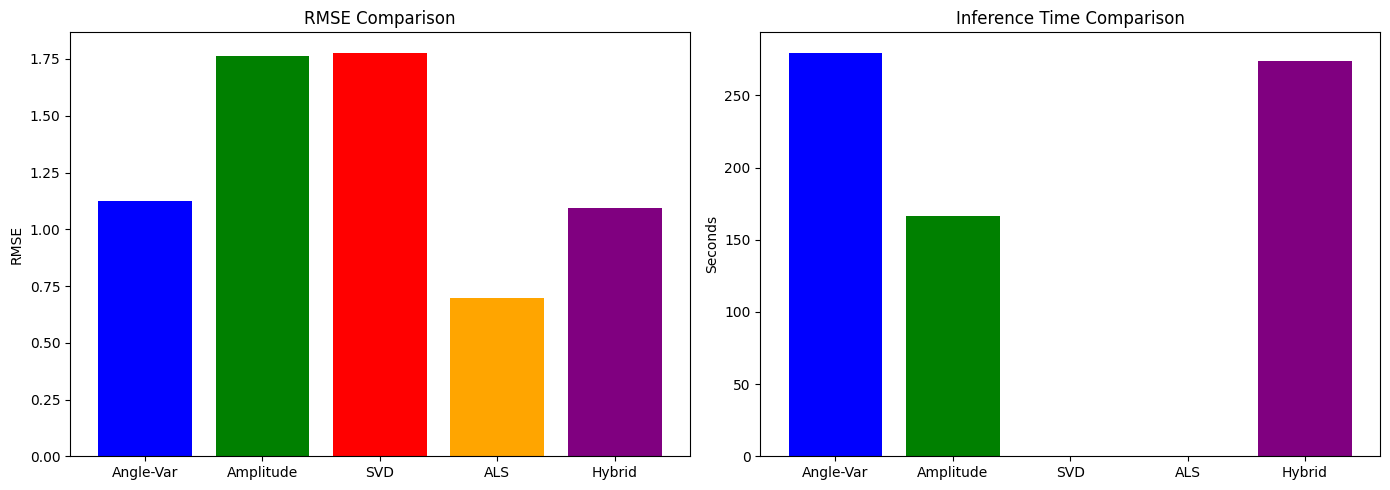

In [ ]:
import matplotlib.pyplot as plt

colors = ["blue", "green", "red", "orange", "purple"]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(df_res["Model"], df_res["RMSE"], color=colors)
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")

axes[1].bar(df_res["Model"], df_res["Time (s)"], color=colors)
axes[1].set_title("Inference Time Comparison")
axes[1].set_ylabel("Seconds")

plt.tight_layout()
plt.show()

# Отчет / Мысли по происходящему и произошедшему

Как и планировал после созвона, сделал полноценное обучение с разбиением на train/valid/test как для классики в качестве baseline, так и для квантовых методов. Пришлось заменить NMF из классики, поскольку столкнулся с проблемой: при изменении гиперпараметров численное значение метрики никак не изменялось. По итогу пришел к выводу, что встроенная в библиотеку реализация учитывает нули при расчете приближенной матрицы (нулей у нас много и они никакой информации не несут), а это нам мешает получать реальные оценки. Маску, игнорирующие нули, поверх готового метода написать не удалось, так что пришлось посмотреть еще какой-либо метод, так что по итогу пришел к ALS, про который вспомнил, поскольку некоторое время назад им интерисовался. Этот метод пришлось реализовать руками, основываясь на описании из Яндекс Хендбука по машинному обучению (в библиотеке implicit этот метод работает с неявным(implicit) фидбеком, т.е. 0/1, а у нас явный(explicit), поэтому и самостоятельная реализация).

По итогу можно видеть, что реализованные квантовые методы по времени затрачивают гораздо больше, чем матричные походы, в которых уже прописано распараллеливание линейной алгебры, а по итогу мощного прироста в метрике не получаем. Еще и значение метрики с использованием LSTM для корректировки (предсказания ошибки) получилось не самым удачным, вероятно из-за некачественного обучения / подбора гиперпараметров, а еще возможно, что из-за изначально подхода предсказания *ошибки* вместо скорректированного предсказания. Думаю, можно было бы поменять этот, казалось бы, незначительный момент (ведь по факту это вопрос предсказания линейного сдвига, так что модель могла бы получить больше информации про имеющиеся предсказания, давай мы ей на на анализ не просто ошибку, а ошибку вместе с предсказанием). Еще недостаток, что помимо повышенного времени, затрачиваемого на исполнение предсказаний, предварительно часть уходит на обучение как Angle-Var, так и LSTM. Соответственно, ресурсов было потрачено гораздо больше, но результата не прибыло. Думаю, в качестве дальнейшего развития также было бы полезно рассмотреть вариант распаралелливания обработки векторов в квантовом варианте (поскольку сейчас каждый вызов предсказания *predict_pair_ang* запускает исполнение QNode, потом занимается переводом в Torch и тд, то это занимает дополнительное время, которое в итоге и выливается в условные 250 секунд на 20.000 предсказаниях). На текущий момент слабо понимаю как работает батчирование вызовов QNode, чтобы сразу N штук векторов обрабатывать. К тому же, имеет смысл подумать над оптимизацией самой квантовой схемы (поработать над глубиной / поворотами в (не)нужных местах и тд).  

Из личных замечаний могу отметить: при черновых прогонах показалось, что добавление количества пар в тренировочный датасет не сильно улучшило точность квантовых предсказаний (без LSTM). Вероятно при детальном анализе это могло бы свидетельствовать о достаточности маленького датасета для получения приемлемого результата. Так что считаю, можно будет с этой темой детальнее дальше разобраться и прикрутить этот вопрос к решению проблемы холодного старта в рекомендательных системах.

Еще из проблем было замечено, что Angle-Var предсказывает значения в узком диапазоне отностительно среднего значения на тренировочном датасете. То есть она как будто бы пытается весьма сильно к среднему значению приблизиться, при этом показывая адекватную метрику, но на деле это ловушка, потому что по факту можно взглянуть на следующие цифры (взяты из ячеек выше: **предсказания** и  **диапазон предсказаний Angle-Var**):

Test mean: 3.579

Test диапазон quantum_pred: 3.40 ... 3.64

По факту мы оказываемся в окрестности среднего значения оценки, что для метрики хорошо, но на деле ничего хорошего в этом нет, потому что мы потенциально как удачные фильмы, так и неудачные, оцениваем одинаково. Тут LSTM как раз спасает (*имеем на train диапазон предсказанной ошибки: -3.19 ... 2.05*), хоть и по чистым цифрам не особо сильный прирост (но качественно, я считаю, стало лучше). Для test забыл вывести😞, но концепт понятен, как мне кажется